In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py


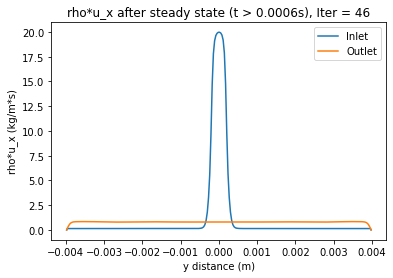

In [12]:
# Specify value of m
# m = 565  # Number of fluid iterations of the simulation
m = 92
mass = np.zeros(m)
temperature = np.zeros(m)
XO2 = np.zeros(m)
XCH4 = np.zeros(m)
XH20 = np.zeros(m)
XCO2 = np.zeros(m)
pressure = np.zeros(m)
min_dot = np.zeros(m)
mout_dot = np.zeros(m)
tin_dot = np.zeros(m)
tout_dot = np.zeros(m)
dt = 2.23001e-06  # [s]
t_end = 0.00125773  # [s]
time = np.arange(0, t_end, dt)

density = np.zeros(m)
vol = np.zeros(m)
vol_out = np.zeros(m)

start = 0
end = 252 
W = 500  # temp value

for i in range(m):
    if (i < 100):
        f = h5py.File(r'C:\Users\Michael\Desktop\data4\sample0\fluid_iter000000' + "{:02d}".format(i) + r'00\0,0,0-751,251,0.hdf', 'r')
    else:
        f = h5py.File(r'C:\Users\Michael\Desktop\data4\sample0\fluid_iter00000' + "{:02d}".format(i) + r'00\0,0,0-751,251,0.hdf', 'r')
    cells = f['cellWidth'][0, :,:]
    volumes = cells[:,:,1] * cells[:,:,2]
    volumes_3d = cells[:,:,1] * cells[:,:,2] * cells[:,:,0]
    # mass[i] = np.sum(f['rho'][0,:,:] * volumes_3d)
    temperature[i] = np.sum(f['temperature'][0,:,:] * volumes_3d) / np.sum(volumes_3d)
    pressure[i] = np.sum(f['pressure'][0,:,:] * volumes_3d) / np.sum(volumes_3d)
    
    # Reshaping array of size 189504 into shape (252, 752, 1), where end = 252
    mass_frac = (f['MolarFracs'][0, :, :][:, :, :] * W) / np.reshape(np.sum(f['MolarFracs'][0, :, :][:, :, :] * W, axis = 2), (252, 752, 1))
    XO2[i] = np.sum(mass_frac[:, :, 1] * f['rho'][0,:,:] * volumes_3d) / np.sum(f['rho'][0,:,:] * volumes_3d)
    XCH4[i] = np.sum(mass_frac[:, :, 0] * f['rho'][0,:,:] * volumes_3d) / np.sum(f['rho'][0,:,:] * volumes_3d)
    XH20[i] = np.sum(mass_frac[:, :, 3] * f['rho'][0,:,:] * volumes_3d) / np.sum(f['rho'][0,:,:] * volumes_3d)
    XCO2[i] = np.sum(mass_frac[:, :, 2] * f['rho'][0,:,:] * volumes_3d) / np.sum(f['rho'][0,:,:] * volumes_3d)
    
    v = f['velocity'][:][:,:,:,0]
    y = f['centerCoordinates'][:][:,:,:,1]
    y_inlet = y[0, :, 0]
    y_outlet = y[0, :, -1]
    dy = y_inlet[2] - y_inlet[1]
    dx = dy
    mass[i] = np.sum(f['rho'][0,:,:]) * dy * dx
    
    density[i] = np.sum(f['rho'][:])
    vol[i] = np.sum(volumes[:, 0])
#     print(f['rho'][:].shape)
#     print(volumes[:, 0].shape)
#     print(v[0, :, 0].shape)
    # min_dot[i] = np.sum(f['rho'][:][0, :, 0] * volumes[:, 0] * v[0, :, 0])
    min_dot[i] = np.sum(f['rho'][:][0, :, 0] * v[0, :, 0]) * (dy)
    
    vol_out[i] = np.sum(volumes[:, -1])
    # mout_dot[i] = np.sum(f['rho'][:][0, :, -1] * volumes[:, -1] * v[0, :, 0])  # -1 for x-index of v?
    mout_dot[i] = np.sum(f['rho'][:][0, :, -1] * v[0, :, -1]) * (dy)
    tin_dot[i] = np.sum(f['temperature'][0, :, 0] * volumes[:, 0] * v[:, 0, 0])
    tout_dot[i] = np.sum(f['temperature'][0, :, -1] * volumes[:, -1] * v[:, -1, 0])
    
    if (i == 0):
        min_wrt_y = f['rho'][:][0, :, 0] * volumes[:, 0] * v[0, :, 0]
    else: 
        min_wrt_y = min_wrt_y + f['rho'][:][0, :, 0] * volumes[:, 0] * v[0, :, 0]
    
    if (i == np.floor(m/2) or i == np.floor(m/2) + 50 or i == np.floor(m/2) + 100 or i == np.floor(m/2) + 150):
        plt.figure()
        rho_ux_in = f['rho'][:][0, :, 0] * v[0, :, 0]
        rho_ux_out = f['rho'][:][0, :, -1] * v[0, :, -1]
        u_y_top = v[0, 0, :]
        u_y_bot = v[0, -1, :]

        plt.plot(y_inlet, rho_ux_in)
        plt.plot(y_outlet, rho_ux_out)
        plt.xlabel("y distance (m)")
        plt.ylabel("rho*u_x (kg/m*s)")
        plt.title("rho*u_x after steady state (t > 0.0006s), Iter = " + str(i))
        
        plt.legend(["Inlet", "Outlet"])
        plt.show()
        

    ## Old Definitions
    # density[i] = np.sum(f['rho'][:][0, start:end, 0])
    # vol[i] = np.sum(volumes[start:end, 0])
    # density_out[i] = np.sum(f['rho'][:][0, :, -1])
    # v = f['velocity'][0,:,:]  
    # min_dot[i] = np.sum(f['rho'][:][0,start:end,0] * volumes[start:end,0] * v[0, :, 0])
    # min_dot[i] = np.sum(f['rho'][0,start:end,0] * volumes[start:end,0] * v[start:end,0,0])
    # mout_dot[i] = np.sum(f['rho'][:][0, :, -1] * volumes[:, -1] * v[0, :, 0])
    # mout_dot[i] = np.sum(f['rho'][0, :, -1] * volumes[:, -1] * v[:, -1, 0])
    # tin_dot[i] = np.sum(f['temperature'][0,start:end,0] * volumes[start:end,0] * v[start:end,0,0])
    
#     ## Print statements for debugging
#     print(v.shape)
#     print(f['velocity'].shape)
#     print(type(f['velocity']))
#     print(f['velocity'][:].shape)

In [6]:
## For various testing
# print(coord.shape)
# print(coord[0, 0, :].shape)
# # print(coord[0, 0, :])
# print(volumes_3d)
time4 = time[0:92]

Text(0, 0.5, 'Pressure (Pa)')

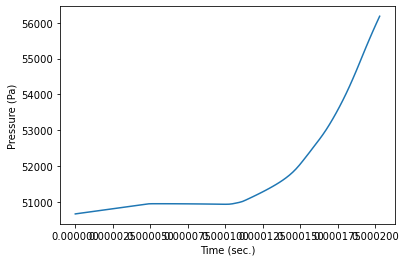

In [7]:
plt.plot(time4, pressure)
plt.xlabel("Time (sec.)")
plt.ylabel("Pressure (Pa)")

Text(0, 0.5, 'Temperature (K)')

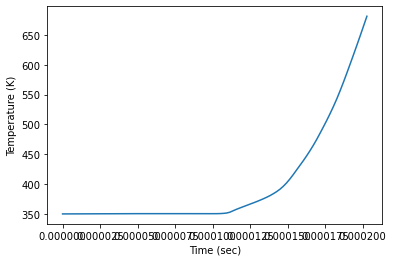

In [9]:
plt.plot(time4, temperature)
plt.xlabel("Time (sec)")
plt.ylabel("Temperature (K)")

Text(0, 0.5, 'Mass Inflow [kg/s]')

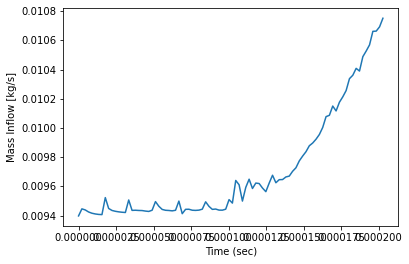

In [10]:
plt.plot(time4, min_dot)
plt.xlabel("Time (sec)")
plt.ylabel("Mass Inflow [kg/s]")

Text(0, 0.5, 'Mass Outflow [kg/s]')

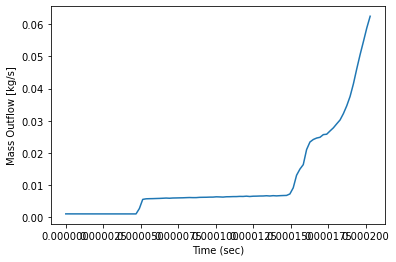

In [13]:
plt.plot(time4, mout_dot)
plt.xlabel("Time (sec)")
plt.ylabel("Mass Outflow [kg/s]")

Text(0, 0.5, 'Total Mass (kg)')

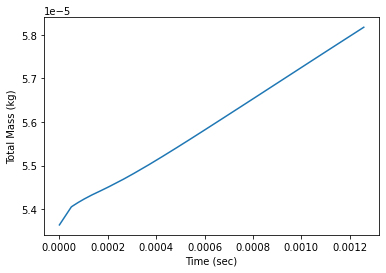

In [4]:
plt.plot(time, mass)
plt.xlabel("Time (sec)")
plt.ylabel("Total Mass (kg)")

Text(0, 0.5, 'Mass Inflow (kg/s)')

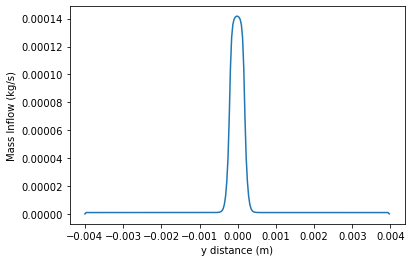

In [93]:
plt.plot(y, min_wrt_y)
plt.xlabel("y distance (m)")
plt.ylabel("Mass Inflow (kg/s)")

Text(0.5, 1.0, 'rho*u_x at inlet, t = 0.0006s')

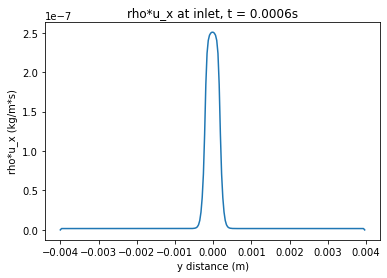

In [49]:
plt.plot(y, rho_ux_in)
plt.xlabel("y distance (m)")
plt.ylabel("rho*u_x (kg/m*s)")
plt.title("rho*u_x at inlet, t = 0.0006s")

Text(0.5, 1.0, 'rho*u_x at outlet, t = 0.0006s')

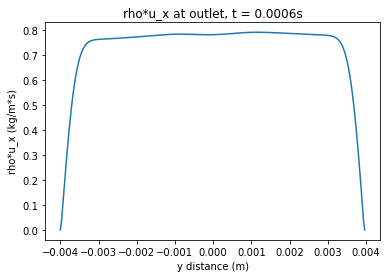

In [91]:
plt.plot(y, rho_ux_out)
plt.xlabel("y distance (m)")
plt.ylabel("rho*u_x (kg/m*s)")
plt.title("rho*u_x at outlet, t = 0.0006s")